# A Short Tutorial on Valda

Author: [Yangfeng Ji](https://yangfengji.net/)

The central task of data valuation is to **estimate the contribution of training examples to the final prediction performance**.

This is a short tutorial of the [Valda](https://uvanlp.org/valda/) package developed by the UVa ILP group. This tutorial is based on valda v0.1.10.
If you find any problems or have any suggestions of this package, please create an issue via [this link](https://github.com/uvanlp/valda/issues).

---

**Note**: the performance of the data valuation methods in this tutorial should *not* be used to decide which method that you will use. This tutorial is to provide demos of how to use Valda, instead of a rigorous comparison of these methods.

Based on our experience, the factors that could affect a data valuation method include

- the hyper-parameters of each method (e.g., number of iterations/permutations in TMC-Shapley)
- the classifier used for valuation (e.g., the ones from Sklearn vs. user-defined classifier), and
- the complexity of a data distribution vs. the capacity of a classifier (e.g., using a linear classifier for a dataset with complicated may not be ideal).

In practice, please take these three factors into your consideration when choosing a method.

---

Now, let's get started.

First, we need to install the package from PyPI.

In [4]:
import valda

Then, we need to download the example data from the package website.

In this tutorial, we will use a small proportion of the `diabetes` dataset. The original dataset can be found via [this OpenML link](https://www.openml.org/search?type=data&sort=runs&id=37&status=active)

In [5]:
import os
import requests
import tarfile

# Removing the file
file_path = "diabetes.*"
if os.path.exists(file_path):
    os.remove(file_path)

# Downloading the file
url = "https://uvanlp.org/data/diabetes.tgz"
response = requests.get(url)
with open("diabetes.tgz", "wb") as f:
    f.write(response.content)

# Extracting the tar file
with tarfile.open("diabetes.tgz", "r:gz") as tar:
    tar.extractall()

In [6]:
from pickle import load
data = load(open('diabetes.pkl', 'rb'))

# The set of examples that will be evaluated
trnX, trnY = data['trnX'], data['trnY']
# We need a development set to value the training examples
devX, devY = data['devX'], data['devY']

print("Dimensions of data: {}".format(trnX.shape[1]))
print("Number of training examples: {}".format(trnX.shape[0]))
print("Number of validation/development examples: {}".format(devX.shape[0]))

Dimensions of data: 8
Number of training examples: 128
Number of validation/development examples: 128


## 1 Data Valuation

We will start from a simple example. Please make sure you can run the following code block before moving to the next one.




### 1.1 A Simple Example

The following code block loads the `DataValuation` class and creates an instance with the training and development sets
- Training set: (trnX, trnY)
- Development set: (devX, devY)

The algorithm will evaluate the contribution of each individual training example, based on the performance change on the development set.

The default data valuation method is `loo` (Leave-one-out), which is simply removing one data point and measuring the performance difference with training on the whole set.

The `estimate()` function returns a Python dictionary of example indices and their corresponding values.


In [7]:
from valda.valuation import DataValuation

# Define a DataValuation instance
dv = DataValuation(trnX, trnY, devX, devY)

# Run with the default setting:
# 1. Logistic regression as the classifier
# 2. Prediction accuracy as the value measurement
vals = dv.estimate()
print(vals)

100%|██████████| 128/128 [00:00<00:00, 246.49it/s]

{0: 0.0, 1: 0.0078125, 2: 0.0078125, 3: 0.0, 4: 0.0234375, 5: 0.0, 6: 0.0234375, 7: 0.0, 8: 0.0078125, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0078125, 13: 0.0, 14: 0.015625, 15: 0.015625, 16: 0.0078125, 17: 0.0078125, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0078125, 26: 0.0, 27: 0.0078125, 28: 0.0078125, 29: 0.0078125, 30: 0.0078125, 31: 0.0078125, 32: 0.0, 33: 0.0078125, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0078125, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.015625, 43: 0.0, 44: 0.0078125, 45: 0.0078125, 46: 0.0, 47: 0.0, 48: 0.0078125, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0078125, 53: 0.0078125, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0078125, 60: 0.0078125, 61: 0.0, 62: 0.0078125, 63: 0.0, 64: 0.0078125, 65: 0.0, 66: 0.0078125, 67: 0.0, 68: 0.015625, 69: 0.0, 70: 0.0078125, 71: 0.0078125, 72: 0.0078125, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.015625, 77: 0.0, 78: 0.0, 79: 0.0078125, 80: 0.0078125, 81: 0.0, 82: 0.0078125, 83: 0.0234375, 84: 0.0078125, 85: 0.0078125, 

### 1.2 Evaluation

A typical way of evaluating a data valuation method is the `data removal` task with the following three steps:

- rank the training examples with a decreasing order of values
- remove one example at a time consecutively from the training set `(trnX, trnY)`, and
- re-train the model to measure the performance drop on the test set `(tstX, tstY)`.

As shown in this block and the following ones, a **better** algorithm will give a much **steeper** performance drop, as the data valuation method successfully identify important training examples.

The default method `loo` usually does not perform good on most of the dataset, but we will try a better one later.

Two ways to present the results of evaluation:

- visualize the performance curve
- calculate the weighted accuracy drop (`weighted_acc_drop`) defined in [(Schoch et al., 2022)](https://arxiv.org/abs/2211.06800)

The weighted accuracy drop is 0.067


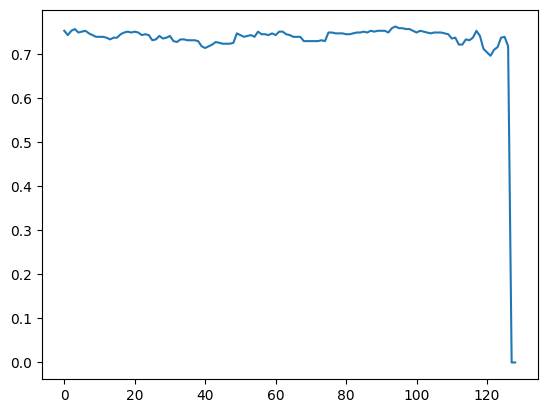

In [8]:
from matplotlib import pyplot as plt

# Import the evaluation task: Data Removal
from valda.eval import data_removal
# Import the evaluation metric: Weighted Accuracy Drop
from valda.metrics import weighted_acc_drop

# For a fair evaluation, we need a separate test set for the final evaluation
tstX, tstY = data['tstX'], data['tstY']

accs = data_removal(vals, trnX, trnY, tstX, tstY)
plt.plot(range(len(accs)), accs)
res = weighted_acc_drop(accs)
print("The weighted accuracy drop is {:.3f}".format(res))

## 2 More Options

The `estimate()` function from the `DataValuation` class takes three parameters

- `method`: the data valuation method, so far the package offers five options
- `clf`: the classification method that used to estimate data values

- `params`: Hyper-parameters for the data valuation methods

We will explain each of the three parameters in the following

### 2.1 Use a Different Data Valuation Method

- `loo`: the Leave-one-out method
- `tmc-shapley`: the Data Shapley method estimated with tuncated Monte Carlo (TMC) [(Ghorbani and Zou, 2019)](https://proceedings.mlr.press/v97/ghorbani19c.html)
- `beta-shapley`: the Beta Shapley method [(Kwon and Zou, 2021)](https://arxiv.org/abs/2110.14049)
- `cs-shapley`: the Class-wise Shapley method in [(Schoch et al. 2022)](https://arxiv.org/abs/2211.06800)
- `inf_func`: the Influence Function method in [(Koh and Liang, 2017)](https://arxiv.org/abs/1703.04730).
    - It only works with the classifiers defined with [PyTorch](https://pytorch.org/), as it needs the gradient computation.
    - To make it consistent with other data valuation methods, in Valda, large IF values mean high-value examples (unlike in the original paper)

Following the previous example, we can change the data valuation method from the default one (`loo`) to the TMC-Shapley (`tmc-shapley`) method

100%|██████████| 500/500 [00:19<00:00, 25.53it/s]


The weighted accuracy drop is 0.352


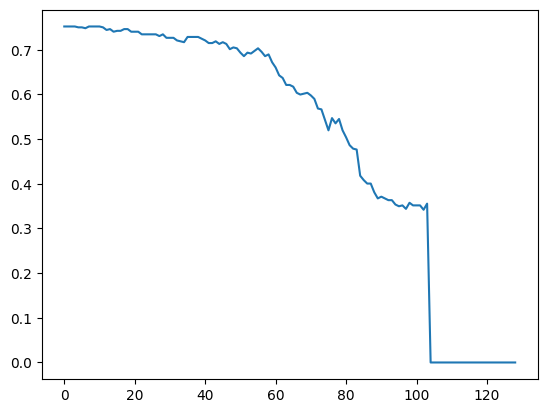

In [9]:
vals = dv.estimate(method='tmc-shapley')

accs = data_removal(vals, trnX, trnY, tstX, tstY)

plt.plot(range(len(accs)), accs)
res = weighted_acc_drop(accs)
print("The weighted accuracy drop is {:.3f}".format(res))

### 2.2 Use a Different Classifier for Valuation

- the package is compatible with the classifiers defined in [Sklearn](https://scikit-learn.org/stable/).
- it also supports user-defined classifiers via PyTorch, as demonstrated in section 3.

Added on the previous example, we can try the data valuation with a different classifier (e.g., decision tree) via the `clf` parameter.

Although the weighted avarage score may be (slightly) different from the one estimated with the lognistic regression classifier, the plot should look similar.

100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


The weighted accuracy drop is 0.329


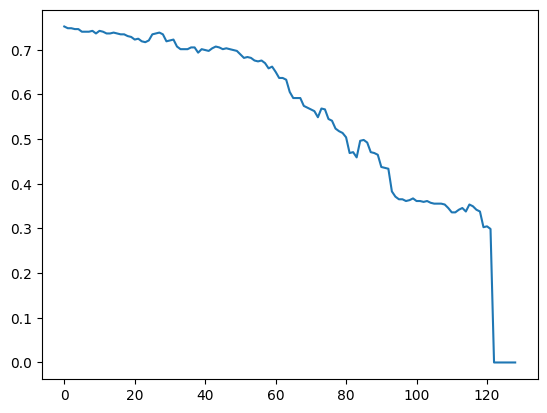

In [10]:
from sklearn.tree import DecisionTreeClassifier


tree_model = DecisionTreeClassifier()

vals = dv.estimate(method='tmc-shapley', clf=tree_model)

accs = data_removal(vals, trnX, trnY, tstX, tstY)

plt.plot(range(len(accs)), accs)
res = weighted_acc_drop(accs)
print("The weighted accuracy drop is {:.3f}".format(res))

### 2.3 Hyperparameters for Data Valuation Methods

Each data valuation method has different hyperparameters, and here is the list of hyperparameters that each method has

- LOO: no hyper-parameter
- TMC Shapley
    - `tmc_iter`: (default: 500) number of iterations/permutations
    - `tmc_thresh`: (default: 0.001) threshold for in truncated Monte Carlo method in each permutation
- Beta Shapley
    - `beta_iter`: (default: 50) number of iterations (similar to the one with TMC-Shapley). Note that, Beta Shapley is a little slower than TMC-Shapley, so we set a small number of iterations by default.
    - `alpha` and `beta`: (default: 1.0 and 16.0) the parameters of Beta distribution
    - `beta_chain`: (default: 10) number of chains for the Monte Carlo method
    - `rho`:
- CS-Shapley
    - `cs_iter`: (default: 500) number of iterations/permutations (similar to the one with TMC-Shapley)
    - `cs_thresh`: (default: 0.001) threshold for in truncated Monte Carlo method (similar to the one with TMC-Shapley
- Influence Function:
    - `if_iter`: (default: 10) number of iterations training the model before computing the gradient. If you have a pre-trained model, which does not need further training, set it to be 0.
    - `second_order_grad`: (default: False) whether using the second-order gradient information for valuation
    - `for_high_value`: (default: True) whether the valuation is to detect high-value examples

`Valda` provides a class `Parameter` to query and revise the values of these hyperparameters, which has three basic functions
- `print_values()`: print all the hyperparameters and their values
- `update({key:val})`: update the hyperparameter `key` with the corresponding value `val`
- `get_values()`: return all the values

For example, you can print out the default values of the hyperparameters.

In [11]:
from valda.params import Parameters

# Create a Parameter instance
params = Parameters()
# Print all the hyperparameters for the data valuation methods supported by Valda
params.print_values()

The current hyper-parameter setting:
	tmc_iter : 500
	tmc_thresh : 0.001
	cs_iter : 500
	cs_thresh : 0.001
	beta_iter : 50
	alpha : 1.0
	beta : 16.0
	rho : 1.0005
	beta_chain : 10
	if_iter : 30
	second_order_grad : False
	for_high_value : True


Following the previous example, if we want to change the number of iterations of TMC-Shapley to 100, here is what we can do

In [12]:
# Update the hyperparameter value
params.update({'tmc_iter':100})

# Double check whether the values of 'tmc_iter' has been changed
params.print_values()

The current hyper-parameter setting:
	tmc_iter : 100
	tmc_thresh : 0.001
	cs_iter : 500
	cs_thresh : 0.001
	beta_iter : 50
	alpha : 1.0
	beta : 16.0
	rho : 1.0005
	beta_chain : 10
	if_iter : 30
	second_order_grad : False
	for_high_value : True


Run TMC-Shapley with the new iteration number. Based on the weighted accuracy drop, we can see a small number of iterations often gives down-graded performance on estimating the data values.

Overload the model parameters with the user specified ones: {'tmc_iter': 100, 'tmc_thresh': 0.001, 'cs_iter': 500, 'cs_thresh': 0.001, 'beta_iter': 50, 'alpha': 1.0, 'beta': 16.0, 'rho': 1.0005, 'beta_chain': 10, 'if_iter': 30, 'second_order_grad': False, 'for_high_value': True}


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


The weighted accuracy drop is 0.192


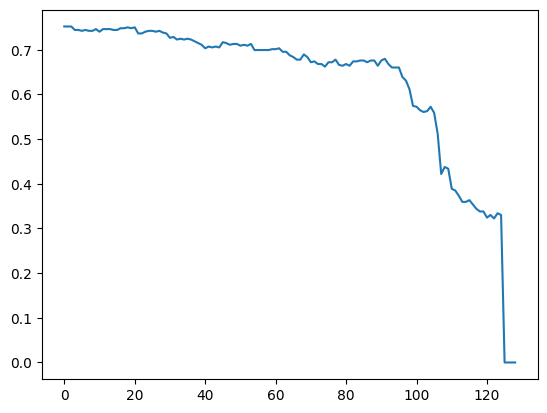

In [13]:
# Run TMC-Shapley with the updated hyperparameters
vals = dv.estimate(method='tmc-shapley',
                   clf=tree_model,
                   params=params.get_values() # Use the updated parameter
                   )

# Run the evaluation code again
accs = data_removal(vals, trnX, trnY, tstX, tstY)

plt.plot(range(len(accs)), accs)
res = weighted_acc_drop(accs)
print("The weighted accuracy drop is {:.3f}".format(res))

## 3 User-defined Classifiers

Valda also support user-defined classifiers. So far, the support is only for the classifiers built with PyTorch. Since by default PyTorch use mini-batch training, Valda provides a scaffolding code to connect PyTorch based models with the rest of the code.

In the following example, we demonstrate how to use user-defined classifiers with Valda.

### 3.1 Logistic Regression with `PytorchClassifier`

First, let's build an LR classifier using PyTorch:

In [14]:
import torch

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        outputs = self.softmax(self.linear(x))
        return outputs


Then, we need some additional pre-processing, as PyTorch does not work with non-numeric labels

In [15]:
from sklearn import preprocessing

labels = list(set(trnY))
le = preprocessing.LabelEncoder()
le.fit(labels)
trnY_num = le.transform(trnY)
devY_num = le.transform(devY)
tstY_num = le.transform(tstY)

Then, we create an instance and use the scaffolding class `PytorchClassifier` provided by Valda to wrap up this instance.

We will provide brief introduction of `PytorchClassifier` in section 3.3. In the following examples, the four parameters used in `PytorchClassifier` are

- `model`: the classifier built with PyTorch
- `epochs`: number of epochs for training this classifier
- `*_batch_size`: the mini batch size for training/development sets

In [16]:
from valda.pyclassifier import PytorchClassifier

model = LogisticRegression(input_dim=trnX.shape[1],
                           output_dim=len(labels))

pt_clf = PytorchClassifier(model, epochs=20, trn_batch_size=16, dev_batch_size=16)

Last, we call the data valuation function to estimate the values. Note that, TMC-Shapley requires re-train the classifier every time when adding one example to the training, and because we use mini-batch training here, the following code should be much **slower** than using the LR classifier defined in `Sklearn`, as shown previously.

However, the benefits of using `PytorchClassifier` are
- it offers the options to use a classifier other than the one provided by `Sklearn`
- more importantly, it allows us to the influence function (`inf-func`) method as demonstrated in section 3.2

In [17]:
dv = DataValuation(trnX, trnY_num, devX, devY_num)
vals = dv.estimate(clf=pt_clf, method='tmc-shapley')

100%|██████████| 500/500 [02:54<00:00,  2.87it/s]


Evaluate the estimated data values using the data removal method.

The weighted accuracy drop is 0.02322910997340045


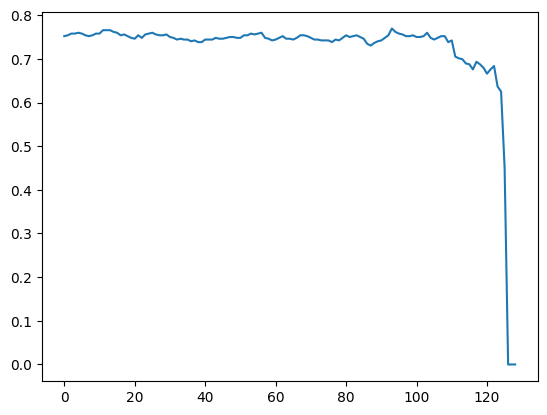

In [18]:
accs = data_removal(vals, trnX, trnY, tstX, tstY)

plt.plot(range(len(accs)), accs)
res = weighted_acc_drop(accs)
print("The weighted accuracy drop is {}".format(res))

### 3.2 Influence Function

With the user-defined classifiers, the way of using influence function is not much different from other data valuation methods in Valda.

As you can see in the printed message when running the following code

- in Valda, large values from IF mean important examples, which is different from the definition in (Koh and Liang, 2017). The only reason we choose this way to make the outputs consistent with other data valuation methods.
- the current implementation only has the first-order gradient computation. In the future version, we will provide the option to let user choose whether they want the second-order gradient (it will be much slower, but supposed to be better in theory)

In [19]:
vals = dv.estimate(clf=pt_clf, method='inf-func')

Training models for IF with 20 iterations ...
Training for high-value example detection ...
In this implementation, large values mean important examples


Now, let's see how the performance of IF looks like

The weighted accuracy drop is 0.2561084775917672


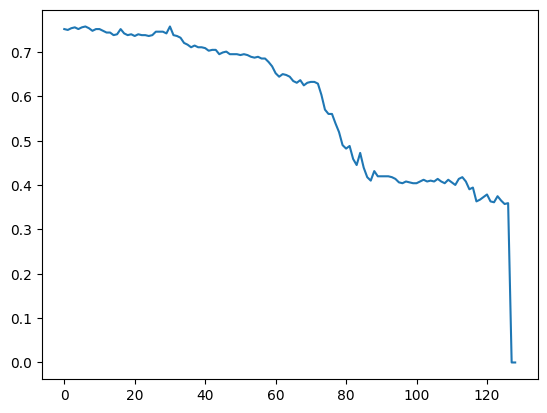

In [20]:
accs = data_removal(vals, trnX, trnY, tstX, tstY)

plt.plot(range(len(accs)), accs)
res = weighted_acc_drop(accs)
print("The weighted accuracy drop is {}".format(res))

### 3.3 The `PytorchClassifier` Class

The class initialization function of `PytorchClassifier` takes six parameters, all of them are related to PyTorch training

- `model`: the classifier defined with PyTorch
- `optim`: an optimizer defined in PyTorch (default: Adam)
- `loss`: a training criterion defined in PyTorch (default: CrossEntropy)
- `epochs`: number of epochs training the classifier (default: 20)
- `trn_batch_size`: the mini-batch size for the training set (default: 16)
- `dev_batch_size`: the mini-batch size for the development set (default: 16)

For example, if we want to use a different optimizer for training the model, here is what we can do

Training models for IF with 20 iterations ...
Training for high-value example detection ...
In this implementation, large values mean important examples
The weighted accuracy drop is 0.2545879125738163


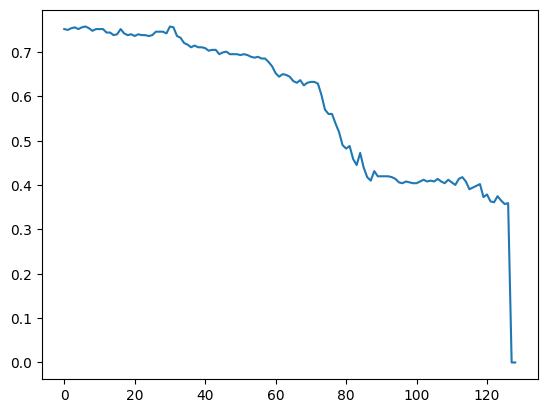

In [21]:
# Create a new optimizer
sgd = torch.optim.SGD(model.parameters(), lr=0.1)

# Repeat what we did before, with the new optimizer
pt_clf = PytorchClassifier(model, optim=sgd, epochs=20, trn_batch_size=16, dev_batch_size=16)

vals = dv.estimate(clf=pt_clf, method='inf-func')

accs = data_removal(vals, trnX, trnY, tstX, tstY)
plt.plot(range(len(accs)), accs)
res = weighted_acc_drop(accs)
print("The weighted accuracy drop is {}".format(res))

## 4 Applications

TODO